# THIS HOMEWORK IS THE REAL DEAL. IF YOU NEED TO TEST DO IT IN `test_model.ipynb`

sike u thought

# Setup

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install dm-haiku
!pip install pretty_midi
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 11.6 MB/s 
     |████████████████████████████████| 51 kB 9.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=53db62101635aa5596dcd056fbbabbbacfa1c5f0a15f0fc9288a78faf9a7dc9a
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty-midi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 12.5 MB/s 
     |████████████████████████████████| 85 kB 4.7 MB/s 


## Imports

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from typing import Union, List, Dict, Tuple

import numpy as np
# import tensorflow as tf
import random

import jax
from jax import value_and_grad
import jax.numpy as jnp
import optax
import haiku as hk

import librosa
import pathlib
from tqdm import tqdm

import matplotlib.pyplot as plt
from pretty_midi import PrettyMIDI

from IPython.display import Audio

import sys
import os
FOLDER_PATH = "/content/drive/MyDrive/badpitches/v3"
sys.path.insert(0, FOLDER_PATH)

from loss import loss_dict
from constants import *
from new_model_in_jax import PosteriorgramModel
# from cqt_and_hs import load_cqt_window, harmonic_stacking, load_and_cqt


In [7]:
from cqt_and_hs import *

## Utility Functions

# Pre-preprocessing (windowing inputs)

In [ ]:
full_midi_path = "/content/drive/MyDrive/badpitches_data/validation_new/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1.midi"
full_wav_path = "/content/drive/MyDrive/badpitches_data/validation_new/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1.wav"
audio_tensor = load_cqt_window(full_wav_path)

In [ ]:
audio_tensor[0].shape

(1, 84, 87, 1)

In [ ]:
N_FREQ_BINS_CONTOURS

264

In [ ]:
raw_audio = librosa.load(full_wav_path, sr=22050)[0]

In [ ]:
length = raw_audio.shape[0]

In [ ]:
audio_windowed = []
for i in range(length // AUDIO_SAMPLE_RATE):
    audio_windowed.append(raw_audio[i * AUDIO_SAMPLE_RATE: (i+1) * AUDIO_SAMPLE_RATE])
audio_windowed = np.array(audio_windowed)
audio_windowed.shape

(329, 22050)

In [ ]:
cqtd_batch = cqt_windowed(audio_windowed)

ParameterError: ignored

In [ ]:
x2 = jnp.arange(16.0).reshape([1,1,4,4])
x2_unf = jax.lax.conv_general_dilated_patches(lhs = x2, filter_shape = [3,3], 
                                                      window_strides = [1,1], padding = [(0,0),
                                                                                        (0,0)])

# Training Attempt
Maybe consider adding a requirements.txt

In [34]:
rng = jax.random.PRNGKey(0)
audio_path = "drive/MyDrive/badpitches/v3/test.m4a"
audio_tensor = load_and_cqt(audio_path)
noisy_audio = audio_tensor + jax.random.normal(rng, audio_tensor.shape)

epochs = 500
learning_rate = 0.001
optimizer = optax.adam(learning_rate)


def update_weights(weights,gradients):
    return optimizer.update(gradients, weights)

def loss_wrapper(params, state, x, y):
    out, new_state = model.apply(params, state, rng=rng, audio_tensor=x, is_training=True)
    loss_fns = loss_dict()
    contour_mat = jnp.expand_dims(jnp.transpose(y["contour"], (0,2,1)), -1)
    note_mat = jnp.expand_dims(jnp.transpose(y["note"], (0,2,1)), -1)
    onset_mat = jnp.expand_dims(jnp.transpose(y["onset"], (0,2,1)), -1)
    loss_yp = jnp.sum(loss_fns["contour"](contour_mat, out[0]))
    loss_yn = jnp.sum(loss_fns["note"](note_mat, out[1]))
    loss_yo = jnp.sum(loss_fns["onset"](onset_mat, out[2]))
    loss = loss_yp + loss_yn + loss_yo
    return loss, (loss, new_state)

def step(params, opt_state, state, x, y):
    # loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    grads, (loss, state) = jax.grad(loss_wrapper, has_aux=True)(params, state, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, state, loss

def model_fn(audio_tensor, is_training):
    """returns (batch, time, freq, ch)"""
    bn = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, name="bn")
    normed = bn(audio_tensor, is_training)
    hs = harmonic_stacking(jnp.transpose(normed, axes=(0,2,1,3)))
    pgram = PosteriorgramModel()(hs, is_training)
    
    return pgram

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [35]:
def audio_info(path, window_len=ANNOT_N_FRAMES, window_num=0):
  """
  Returns the onset, contour, and note matrices as a dictionary for the appropriate
  window of the MIDI file located at the given path.
  returns (batch, freq, time)
  """

  midi_fps = ANNOTATIONS_FPS

  pm = PrettyMIDI(path)

  start_frame = window_num * window_len
  end_frame = (window_num + 1) * window_len
  note_matrix = pm.get_piano_roll(fs=midi_fps)[21:109, start_frame:end_frame] / 127 #21 to 109 is piano bins

  onsets = np.array(pm.get_onsets() * midi_fps)
  logical_indices = np.logical_and(start_frame < onsets, onsets < end_frame)
  windowed_onsets = np.floor(onsets[logical_indices] - start_frame)

  onset_matrix = np.zeros_like(note_matrix, dtype=bool)
  
  for frame in windowed_onsets.astype(int):
    vec = note_matrix[: , frame]
    prev_vec = note_matrix[: , max(0, frame - 1)]
    onset_notes = np.argwhere(vec - prev_vec).ravel()
    for note in onset_notes:
      onset_matrix[note][frame] = True

  contour_array = [(row if i == 1 else np.zeros(row.shape)) for i in range(3) for row in note_matrix]

  return {
    "onset": jnp.array(onset_matrix),
    "contour": jnp.array(contour_array),
    "note": jnp.array(note_matrix)
  }

In [36]:
data_path = "/content/drive/MyDrive/badpitches_data/test_new/"
val_files = os.listdir(data_path)
files = [va.split(".")[0] for va in val_files if va.split(".")[-1] == 'midi']

In [37]:
batched_inputs = np.zeros((BATCH_SIZE, 264, 173, 1))
batched_outputs = {
    'note': np.zeros((BATCH_SIZE, N_FREQ_BINS_NOTES, ANNOT_N_FRAMES)),
    'contour': np.zeros((BATCH_SIZE, N_FREQ_BINS_CONTOURS, ANNOT_N_FRAMES)),
    'onset': np.zeros((BATCH_SIZE, N_FREQ_BINS_NOTES, ANNOT_N_FRAMES))
}

def get_new_batch():
  i = 0
  while i < BATCH_SIZE:
    rand_file_name = files[random.randint(0, len(files) - 1)]
    midi_file = data_path + rand_file_name + ".midi"
    wav_file = data_path + rand_file_name + ".wav"
    audio, window_num = load_cqt_window(wav_file)
    if audio[0].shape != batched_inputs[0].shape:
      continue
    matrices = audio_info(midi_file, window_num=window_num)
    batched_inputs[i,:,:,:] = audio
    batched_outputs['note'][i,:,:] = matrices['note']
    batched_outputs['contour'][i,:,:] = matrices['contour']
    batched_outputs['onset'][i,:,:] = matrices['onset']
    i += 1

In [38]:
model = hk.transform_with_state(model_fn)
params, state = model.init(rng, batched_inputs, True) # pass in augmented data here to train
opt_state = optimizer.init(params)
for _ in tqdm(range(epochs)):
  get_new_batch()
  params, opt_state, state, loss = step(params, opt_state, state, batched_inputs, batched_outputs)
  print(loss)

/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=345
  warnings.warn(
  0%|          | 1/50

616422.0


  0%|          | 2/500 [00:14<1:01:11,  7.37s/it]

604494.56


  1%|          | 3/500 [00:21<1:00:10,  7.27s/it]

598602.4


  1%|          | 4/500 [00:30<1:04:02,  7.75s/it]

593628.44


  1%|          | 5/500 [00:37<1:01:02,  7.40s/it]

588136.75


  1%|          | 6/500 [00:42<55:57,  6.80s/it]  

582910.06


  1%|▏         | 7/500 [00:50<59:51,  7.29s/it]

579362.5


  2%|▏         | 8/500 [00:56<56:16,  6.86s/it]

574048.7


  2%|▏         | 9/500 [01:03<56:34,  6.91s/it]

570321.94


  2%|▏         | 10/500 [01:13<1:03:33,  7.78s/it]

564204.4


  2%|▏         | 11/500 [01:21<1:03:47,  7.83s/it]

560418.25


  2%|▏         | 12/500 [01:26<57:12,  7.03s/it]  

554590.8


  3%|▎         | 13/500 [01:36<1:02:57,  7.76s/it]

554246.8


  3%|▎         | 14/500 [01:43<1:01:20,  7.57s/it]

550705.6


  3%|▎         | 15/500 [01:51<1:01:51,  7.65s/it]

547597.25


  3%|▎         | 16/500 [01:58<1:01:53,  7.67s/it]

542979.56


  3%|▎         | 17/500 [02:05<58:17,  7.24s/it]  

540234.56


  4%|▎         | 18/500 [02:14<1:03:10,  7.86s/it]

536412.56


  4%|▍         | 19/500 [02:20<57:45,  7.20s/it]  

534540.6


  4%|▍         | 20/500 [02:28<59:08,  7.39s/it]

532092.8


  4%|▍         | 21/500 [02:36<1:00:39,  7.60s/it]

531105.1


  4%|▍         | 22/500 [02:43<59:38,  7.49s/it]  

524597.9


  5%|▍         | 23/500 [02:51<1:00:30,  7.61s/it]

524779.8


  5%|▍         | 24/500 [02:57<56:15,  7.09s/it]  

525515.06


  5%|▌         | 25/500 [03:06<1:01:26,  7.76s/it]

521491.75


  5%|▌         | 26/500 [03:13<59:08,  7.49s/it]  

518269.28


  5%|▌         | 27/500 [03:19<55:36,  7.05s/it]

518176.78


  6%|▌         | 28/500 [03:24<51:46,  6.58s/it]

516108.9


  6%|▌         | 29/500 [03:29<47:48,  6.09s/it]

514483.4


  6%|▌         | 30/500 [03:37<51:32,  6.58s/it]

512512.5


  6%|▌         | 31/500 [03:44<52:58,  6.78s/it]

511447.56


  6%|▋         | 32/500 [03:50<49:38,  6.36s/it]

510812.03


  7%|▋         | 33/500 [03:57<52:38,  6.76s/it]

510519.8


  7%|▋         | 34/500 [04:05<54:15,  6.99s/it]

509579.72


  7%|▋         | 35/500 [04:12<53:55,  6.96s/it]

507712.72


  7%|▋         | 36/500 [04:20<56:18,  7.28s/it]

507136.78


  7%|▋         | 37/500 [04:27<56:21,  7.30s/it]

506110.3


  8%|▊         | 38/500 [04:33<53:54,  7.00s/it]

505929.6


  8%|▊         | 39/500 [04:40<53:33,  6.97s/it]

505072.75


  8%|▊         | 40/500 [04:49<56:22,  7.35s/it]

504602.9


  8%|▊         | 41/500 [04:55<54:30,  7.13s/it]

503854.75


  8%|▊         | 42/500 [05:03<55:22,  7.25s/it]

503457.62


  9%|▊         | 43/500 [05:09<53:59,  7.09s/it]

501667.7


  9%|▉         | 44/500 [05:16<52:05,  6.85s/it]

502160.88


  9%|▉         | 45/500 [05:22<50:39,  6.68s/it]

501487.6


  9%|▉         | 46/500 [05:29<51:42,  6.83s/it]

501077.2


  9%|▉         | 47/500 [05:37<53:14,  7.05s/it]

500158.3


 10%|▉         | 48/500 [05:44<54:17,  7.21s/it]

499154.75


 10%|▉         | 49/500 [05:51<53:10,  7.07s/it]

498965.3


 10%|█         | 50/500 [05:57<50:43,  6.76s/it]

499196.12


 10%|█         | 51/500 [06:03<49:13,  6.58s/it]

499107.9


 10%|█         | 52/500 [06:11<51:26,  6.89s/it]

497620.75


 11%|█         | 53/500 [06:16<47:33,  6.38s/it]

497549.88


 11%|█         | 54/500 [06:25<53:32,  7.20s/it]

497284.44


 11%|█         | 55/500 [06:34<56:52,  7.67s/it]

496933.62


 11%|█         | 56/500 [06:42<57:31,  7.77s/it]

496084.22


 11%|█▏        | 57/500 [06:49<56:26,  7.65s/it]

495717.2


 12%|█▏        | 58/500 [06:56<54:19,  7.37s/it]

495753.06


 12%|█▏        | 59/500 [07:03<54:14,  7.38s/it]

495129.7


 12%|█▏        | 60/500 [07:10<52:50,  7.21s/it]

495389.84


 12%|█▏        | 61/500 [07:17<52:00,  7.11s/it]

494693.78


 12%|█▏        | 62/500 [07:23<50:16,  6.89s/it]

494038.56


 13%|█▎        | 63/500 [07:30<48:47,  6.70s/it]

493889.5


 13%|█▎        | 64/500 [07:33<42:12,  5.81s/it]

494770.38


 13%|█▎        | 65/500 [07:41<45:33,  6.28s/it]

493463.0


 13%|█▎        | 66/500 [07:50<52:35,  7.27s/it]

493732.88


 13%|█▎        | 67/500 [07:58<54:10,  7.51s/it]

493292.62


 14%|█▎        | 68/500 [08:07<55:15,  7.68s/it]

493078.06


 14%|█▍        | 69/500 [08:13<52:35,  7.32s/it]

493162.5


 14%|█▍        | 70/500 [08:19<49:59,  6.98s/it]

493127.75


 14%|█▍        | 71/500 [08:26<50:21,  7.04s/it]

491489.5


 14%|█▍        | 72/500 [08:34<51:22,  7.20s/it]

492510.5


 15%|█▍        | 73/500 [08:41<50:03,  7.03s/it]

492558.5


 15%|█▍        | 74/500 [08:48<49:48,  7.01s/it]

491507.4


 15%|█▌        | 75/500 [08:55<50:09,  7.08s/it]

491609.3


 15%|█▌        | 76/500 [09:00<46:47,  6.62s/it]

490787.75


 15%|█▌        | 77/500 [09:09<50:18,  7.14s/it]

491464.12


 16%|█▌        | 78/500 [09:17<52:30,  7.47s/it]

490791.62


 16%|█▌        | 79/500 [09:23<48:40,  6.94s/it]

491624.72


 16%|█▌        | 80/500 [09:29<48:18,  6.90s/it]

490817.7


 16%|█▌        | 81/500 [09:37<48:45,  6.98s/it]

490833.94


 16%|█▋        | 82/500 [09:44<49:01,  7.04s/it]

489676.16


 17%|█▋        | 83/500 [09:50<46:17,  6.66s/it]

491204.2


 17%|█▋        | 84/500 [09:56<46:26,  6.70s/it]

489523.0


 17%|█▋        | 85/500 [10:02<44:28,  6.43s/it]

490319.8


 17%|█▋        | 86/500 [10:08<42:58,  6.23s/it]

490230.44


 17%|█▋        | 87/500 [10:16<47:22,  6.88s/it]

490341.38


 18%|█▊        | 88/500 [10:23<46:13,  6.73s/it]

489629.8


 18%|█▊        | 89/500 [10:30<48:08,  7.03s/it]

489854.9


 18%|█▊        | 90/500 [10:38<49:28,  7.24s/it]

490310.94


 18%|█▊        | 91/500 [10:43<45:13,  6.63s/it]

490226.8


 18%|█▊        | 92/500 [10:49<43:39,  6.42s/it]

489625.2


 19%|█▊        | 93/500 [10:54<39:39,  5.85s/it]

490011.12


 19%|█▉        | 94/500 [11:02<43:22,  6.41s/it]

489289.7


 19%|█▉        | 95/500 [11:06<39:03,  5.79s/it]

489883.78


 19%|█▉        | 96/500 [11:12<39:56,  5.93s/it]

489438.22


 19%|█▉        | 97/500 [11:18<39:52,  5.94s/it]

489377.7


 20%|█▉        | 98/500 [11:25<41:36,  6.21s/it]

489042.44


 20%|█▉        | 99/500 [11:31<41:40,  6.23s/it]

488086.84


 20%|██        | 100/500 [11:37<41:14,  6.19s/it]

488626.56


 20%|██        | 101/500 [11:44<42:02,  6.32s/it]

488884.1


 20%|██        | 102/500 [11:52<45:33,  6.87s/it]

488399.94


 21%|██        | 103/500 [11:59<45:51,  6.93s/it]

488402.8


 21%|██        | 104/500 [12:06<46:12,  7.00s/it]

487288.06


 21%|██        | 105/500 [12:11<41:41,  6.33s/it]

488230.78


 21%|██        | 106/500 [12:17<41:35,  6.33s/it]

487627.34


 21%|██▏       | 107/500 [12:23<39:59,  6.11s/it]

488056.56


 22%|██▏       | 108/500 [12:27<36:08,  5.53s/it]

486260.2


 22%|██▏       | 109/500 [12:33<36:39,  5.63s/it]

488266.03


 22%|██▏       | 110/500 [12:42<42:02,  6.47s/it]

487957.38


 22%|██▏       | 111/500 [12:49<43:58,  6.78s/it]

487559.62


 22%|██▏       | 112/500 [12:55<41:34,  6.43s/it]

487764.94


 23%|██▎       | 113/500 [13:01<42:02,  6.52s/it]

487564.38


 23%|██▎       | 114/500 [13:08<42:39,  6.63s/it]

487937.8


 23%|██▎       | 115/500 [13:14<40:45,  6.35s/it]

488007.78


 23%|██▎       | 116/500 [13:20<39:09,  6.12s/it]

487690.62


 23%|██▎       | 117/500 [13:25<37:53,  5.93s/it]

487235.47


 24%|██▎       | 118/500 [13:31<38:42,  6.08s/it]

487154.3


 24%|██▍       | 119/500 [13:39<41:08,  6.48s/it]

486984.47


 24%|██▍       | 120/500 [13:46<42:09,  6.66s/it]

487114.8


 24%|██▍       | 121/500 [13:52<40:07,  6.35s/it]

487651.56


 24%|██▍       | 122/500 [13:58<39:53,  6.33s/it]

487204.3


 25%|██▍       | 123/500 [14:04<38:53,  6.19s/it]

487817.38


 25%|██▍       | 124/500 [14:10<39:24,  6.29s/it]

486186.25


 25%|██▌       | 125/500 [14:16<38:54,  6.22s/it]

486726.6


 25%|██▌       | 126/500 [14:23<38:59,  6.25s/it]

487170.62


 25%|██▌       | 127/500 [14:31<42:35,  6.85s/it]

486758.2


 26%|██▌       | 128/500 [14:37<40:17,  6.50s/it]

487170.88


 26%|██▌       | 129/500 [14:43<40:59,  6.63s/it]

487029.94


 26%|██▌       | 130/500 [14:49<37:54,  6.15s/it]

487360.78


 26%|██▌       | 131/500 [14:56<40:13,  6.54s/it]

486644.3


 26%|██▋       | 132/500 [15:02<38:26,  6.27s/it]

486524.94


 27%|██▋       | 133/500 [15:07<36:46,  6.01s/it]

486652.44


 27%|██▋       | 134/500 [15:14<38:04,  6.24s/it]

486857.03


 27%|██▋       | 135/500 [15:20<38:21,  6.30s/it]

486664.25


 27%|██▋       | 136/500 [15:26<37:12,  6.13s/it]

486585.6


 27%|██▋       | 137/500 [15:32<36:44,  6.07s/it]

486440.78


 28%|██▊       | 138/500 [15:37<35:08,  5.82s/it]

487139.16


 28%|██▊       | 139/500 [15:45<38:48,  6.45s/it]

486473.94


 28%|██▊       | 140/500 [15:54<42:45,  7.13s/it]

486716.2


 28%|██▊       | 141/500 [16:02<44:46,  7.48s/it]

486039.56


 28%|██▊       | 142/500 [16:10<45:56,  7.70s/it]

486425.84


 29%|██▊       | 143/500 [16:16<42:41,  7.18s/it]

486376.3


 29%|██▉       | 144/500 [16:23<42:03,  7.09s/it]

486748.16


 29%|██▉       | 145/500 [16:31<42:32,  7.19s/it]

485734.2


 29%|██▉       | 146/500 [16:37<41:44,  7.07s/it]

485896.2


 29%|██▉       | 147/500 [16:43<39:50,  6.77s/it]

486612.66


 30%|██▉       | 148/500 [16:50<39:28,  6.73s/it]

486094.94


 30%|██▉       | 149/500 [16:55<35:44,  6.11s/it]

486417.72


 30%|███       | 150/500 [17:02<37:10,  6.37s/it]

486255.06


 30%|███       | 151/500 [17:07<35:36,  6.12s/it]

485993.12


 30%|███       | 152/500 [17:14<36:41,  6.33s/it]

485546.0


 31%|███       | 153/500 [17:21<37:20,  6.46s/it]

485986.38


 31%|███       | 154/500 [17:26<34:44,  6.02s/it]

485378.56


 31%|███       | 155/500 [17:32<35:31,  6.18s/it]

485695.38


 31%|███       | 156/500 [17:39<37:04,  6.47s/it]

485218.88


 31%|███▏      | 157/500 [17:48<40:42,  7.12s/it]

485695.66


 32%|███▏      | 158/500 [17:54<38:21,  6.73s/it]

485714.0


 32%|███▏      | 159/500 [18:01<39:11,  6.90s/it]

486099.28


 32%|███▏      | 160/500 [18:09<39:53,  7.04s/it]

486197.4


 32%|███▏      | 161/500 [18:16<39:47,  7.04s/it]

486129.22


 32%|███▏      | 162/500 [18:23<39:45,  7.06s/it]

486027.56


 33%|███▎      | 163/500 [18:30<39:30,  7.04s/it]

485801.56


 33%|███▎      | 164/500 [18:36<38:22,  6.85s/it]

486238.56


 33%|███▎      | 165/500 [18:43<38:24,  6.88s/it]

486002.75


 33%|███▎      | 166/500 [18:50<38:15,  6.87s/it]

486135.25


 33%|███▎      | 167/500 [18:58<40:49,  7.36s/it]

485396.2


 34%|███▎      | 168/500 [19:07<42:48,  7.74s/it]

485430.53


 34%|███▍      | 169/500 [19:16<44:53,  8.14s/it]

485185.16


 34%|███▍      | 170/500 [19:24<45:02,  8.19s/it]

485635.56


 34%|███▍      | 171/500 [19:30<41:03,  7.49s/it]

485224.03


 34%|███▍      | 172/500 [19:35<36:15,  6.63s/it]

485490.78


 35%|███▍      | 173/500 [19:41<34:41,  6.36s/it]

485691.8


 35%|███▍      | 174/500 [19:47<34:38,  6.38s/it]

486007.3


 35%|███▌      | 175/500 [19:54<34:53,  6.44s/it]

485228.0


 35%|███▌      | 176/500 [20:02<37:49,  7.00s/it]

485216.28


 35%|███▌      | 177/500 [20:08<35:51,  6.66s/it]

485583.56


 36%|███▌      | 178/500 [20:14<35:15,  6.57s/it]

485108.06


 36%|███▌      | 179/500 [20:22<36:35,  6.84s/it]

485667.72


 36%|███▌      | 180/500 [20:27<33:57,  6.37s/it]

485513.12


 36%|███▌      | 181/500 [20:34<35:05,  6.60s/it]

485583.12


 36%|███▋      | 182/500 [20:42<36:15,  6.84s/it]

485190.34


 37%|███▋      | 183/500 [20:48<35:10,  6.66s/it]

485938.8


 37%|███▋      | 184/500 [20:56<37:28,  7.12s/it]

485578.78


 37%|███▋      | 185/500 [21:02<35:52,  6.83s/it]

485940.66


 37%|███▋      | 186/500 [21:10<37:30,  7.17s/it]

485946.22


 37%|███▋      | 187/500 [21:17<37:04,  7.11s/it]

485647.56


 38%|███▊      | 188/500 [21:23<35:45,  6.88s/it]

485891.62


 38%|███▊      | 189/500 [21:29<34:19,  6.62s/it]

485452.88


 38%|███▊      | 190/500 [21:37<35:11,  6.81s/it]

484641.56


 38%|███▊      | 191/500 [21:44<35:51,  6.96s/it]

485280.9


 38%|███▊      | 192/500 [21:52<37:42,  7.34s/it]

485602.66


 39%|███▊      | 193/500 [21:59<37:03,  7.24s/it]

485651.12


 39%|███▉      | 194/500 [22:06<36:06,  7.08s/it]

485081.28


 39%|███▉      | 195/500 [22:12<33:51,  6.66s/it]

485117.5


 39%|███▉      | 196/500 [22:18<32:48,  6.47s/it]

484906.72


 39%|███▉      | 197/500 [22:24<32:15,  6.39s/it]

485958.4


 40%|███▉      | 198/500 [22:31<33:07,  6.58s/it]

485736.9


 40%|███▉      | 199/500 [22:37<32:35,  6.50s/it]

485126.12


 40%|████      | 200/500 [22:42<30:22,  6.08s/it]

486062.3


 40%|████      | 201/500 [22:50<33:06,  6.64s/it]

485372.2


 40%|████      | 202/500 [22:57<33:20,  6.71s/it]

485179.8


 41%|████      | 203/500 [23:04<33:28,  6.76s/it]

485386.44


 41%|████      | 204/500 [23:10<32:07,  6.51s/it]

485027.22


 41%|████      | 205/500 [23:18<34:24,  7.00s/it]

485094.62


 41%|████      | 206/500 [23:24<32:20,  6.60s/it]

485279.8


 41%|████▏     | 207/500 [23:30<32:07,  6.58s/it]

485371.25


 42%|████▏     | 208/500 [23:37<32:38,  6.71s/it]

485795.3


 42%|████▏     | 209/500 [23:44<32:13,  6.64s/it]

485179.75


 42%|████▏     | 210/500 [23:49<30:50,  6.38s/it]

483564.12


 42%|████▏     | 211/500 [23:55<28:55,  6.00s/it]

485633.25


 42%|████▏     | 212/500 [23:59<26:50,  5.59s/it]

485761.75


 43%|████▎     | 213/500 [24:07<29:27,  6.16s/it]

485389.72


 43%|████▎     | 214/500 [24:15<33:07,  6.95s/it]

485408.75


 43%|████▎     | 215/500 [24:21<31:28,  6.63s/it]

484926.2


 43%|████▎     | 216/500 [24:27<29:59,  6.34s/it]

485319.62


 43%|████▎     | 217/500 [24:33<29:54,  6.34s/it]

484734.12


 44%|████▎     | 218/500 [24:39<28:38,  6.09s/it]

485410.47


 44%|████▍     | 219/500 [24:47<31:07,  6.65s/it]

485057.75


 44%|████▍     | 220/500 [24:56<33:57,  7.28s/it]

485303.06


 44%|████▍     | 221/500 [25:03<33:30,  7.21s/it]

484560.72


 44%|████▍     | 222/500 [25:10<33:27,  7.22s/it]

484606.7


 45%|████▍     | 223/500 [25:18<34:27,  7.46s/it]

485439.72


 45%|████▍     | 224/500 [25:24<31:45,  6.90s/it]

485197.78


 45%|████▌     | 225/500 [25:30<31:14,  6.82s/it]

484990.12


 45%|████▌     | 226/500 [25:37<31:32,  6.91s/it]

485026.0


 45%|████▌     | 227/500 [25:46<33:33,  7.38s/it]

485317.88


 46%|████▌     | 228/500 [25:50<29:35,  6.53s/it]

485367.44


 46%|████▌     | 229/500 [25:57<30:20,  6.72s/it]

485332.5


 46%|████▌     | 230/500 [26:03<28:17,  6.29s/it]

485599.94


 46%|████▌     | 231/500 [26:10<29:24,  6.56s/it]

483537.5


 46%|████▋     | 232/500 [26:19<33:19,  7.46s/it]

485347.25


 47%|████▋     | 233/500 [26:26<32:35,  7.32s/it]

485128.84


 47%|████▋     | 234/500 [26:35<34:04,  7.69s/it]

485357.4


 47%|████▋     | 235/500 [26:42<33:19,  7.55s/it]

484885.62


 47%|████▋     | 236/500 [26:48<30:44,  6.99s/it]

485217.94


 47%|████▋     | 237/500 [26:54<30:02,  6.85s/it]

485577.9


 48%|████▊     | 238/500 [27:01<28:56,  6.63s/it]

484169.28


 48%|████▊     | 239/500 [27:06<27:46,  6.38s/it]

484051.03


 48%|████▊     | 240/500 [27:12<27:09,  6.27s/it]

485356.3


 48%|████▊     | 241/500 [27:21<30:46,  7.13s/it]

485172.56


 48%|████▊     | 242/500 [27:27<28:41,  6.67s/it]

485496.34


 49%|████▊     | 243/500 [27:36<31:07,  7.27s/it]

485146.88


 49%|████▉     | 244/500 [27:42<29:56,  7.02s/it]

484629.56


 49%|████▉     | 245/500 [27:49<28:57,  6.81s/it]

485166.66


 49%|████▉     | 246/500 [27:54<27:31,  6.50s/it]

485610.25


 49%|████▉     | 247/500 [28:02<28:25,  6.74s/it]

484714.2


 50%|████▉     | 248/500 [28:08<28:06,  6.69s/it]

484822.94


 50%|████▉     | 249/500 [28:14<26:47,  6.40s/it]

485173.75


 50%|█████     | 250/500 [28:21<27:55,  6.70s/it]

484023.56


 50%|█████     | 251/500 [28:28<28:23,  6.84s/it]

485012.0


 50%|█████     | 252/500 [28:36<29:10,  7.06s/it]

484841.56


 51%|█████     | 253/500 [28:41<27:03,  6.57s/it]

485334.4


 51%|█████     | 254/500 [28:48<26:51,  6.55s/it]

484511.1


 51%|█████     | 255/500 [28:55<27:27,  6.72s/it]

485051.5


 51%|█████     | 256/500 [29:02<27:43,  6.82s/it]

484909.56


 51%|█████▏    | 257/500 [29:10<28:32,  7.05s/it]

485036.5


 52%|█████▏    | 258/500 [29:16<28:03,  6.96s/it]

485469.1


 52%|█████▏    | 259/500 [29:21<25:20,  6.31s/it]

484753.75


 52%|█████▏    | 260/500 [29:30<28:01,  7.01s/it]

484921.22


 52%|█████▏    | 261/500 [29:38<29:24,  7.38s/it]

485272.06


 52%|█████▏    | 262/500 [29:44<27:27,  6.92s/it]

485109.2


 53%|█████▎    | 263/500 [29:49<24:57,  6.32s/it]

485245.9


 53%|█████▎    | 264/500 [29:55<24:04,  6.12s/it]

484414.66


 53%|█████▎    | 265/500 [30:00<22:46,  5.82s/it]

485491.62


 53%|█████▎    | 266/500 [30:05<22:06,  5.67s/it]

485207.66


 53%|█████▎    | 267/500 [30:11<22:53,  5.90s/it]

484965.75


 54%|█████▎    | 268/500 [30:21<26:36,  6.88s/it]

485111.3


 54%|█████▍    | 269/500 [30:27<25:41,  6.67s/it]

484386.0


 54%|█████▍    | 270/500 [30:32<23:48,  6.21s/it]

484704.44


 54%|█████▍    | 271/500 [30:39<24:23,  6.39s/it]

484979.7


 54%|█████▍    | 272/500 [30:46<25:30,  6.71s/it]

485211.78


 55%|█████▍    | 273/500 [30:54<26:24,  6.98s/it]

484408.47


 55%|█████▍    | 274/500 [31:00<25:10,  6.68s/it]

485543.97


 55%|█████▌    | 275/500 [31:05<23:41,  6.32s/it]

485348.4


 55%|█████▌    | 276/500 [31:12<24:20,  6.52s/it]

485396.56


 55%|█████▌    | 277/500 [31:19<24:45,  6.66s/it]

485199.72


 56%|█████▌    | 278/500 [31:26<24:52,  6.72s/it]

485048.6


 56%|█████▌    | 279/500 [31:35<26:43,  7.26s/it]

485578.3


 56%|█████▌    | 280/500 [31:42<26:21,  7.19s/it]

484721.56


 56%|█████▌    | 281/500 [31:47<24:34,  6.73s/it]

484844.72


 56%|█████▋    | 282/500 [31:54<24:11,  6.66s/it]

485104.75


 57%|█████▋    | 283/500 [31:59<22:56,  6.34s/it]

484922.84


 57%|█████▋    | 284/500 [32:07<24:18,  6.75s/it]

485712.06


 57%|█████▋    | 285/500 [32:14<24:42,  6.89s/it]

485470.34


 57%|█████▋    | 286/500 [32:19<22:30,  6.31s/it]

485379.5


 57%|█████▋    | 287/500 [32:25<21:32,  6.07s/it]

485325.84


 58%|█████▊    | 288/500 [32:30<20:59,  5.94s/it]

485220.56


 58%|█████▊    | 289/500 [32:38<22:22,  6.36s/it]

484730.06


 58%|█████▊    | 290/500 [32:43<21:35,  6.17s/it]

485501.7


 58%|█████▊    | 291/500 [32:51<22:55,  6.58s/it]

484424.84


 58%|█████▊    | 292/500 [32:57<22:24,  6.46s/it]

485248.06


 59%|█████▊    | 293/500 [33:04<22:57,  6.66s/it]

485010.25


 59%|█████▉    | 294/500 [33:09<20:38,  6.01s/it]

485327.94


 59%|█████▉    | 295/500 [33:16<21:43,  6.36s/it]

484924.12


 59%|█████▉    | 296/500 [33:21<20:39,  6.08s/it]

484750.9


 59%|█████▉    | 297/500 [33:29<22:10,  6.55s/it]

484684.28


 60%|█████▉    | 298/500 [33:37<23:51,  7.09s/it]

485305.22


 60%|█████▉    | 299/500 [33:43<22:27,  6.71s/it]

484647.06


 60%|██████    | 300/500 [33:49<20:58,  6.29s/it]

485458.94


 60%|██████    | 301/500 [33:57<23:24,  7.06s/it]

484611.62


 60%|██████    | 302/500 [34:02<20:37,  6.25s/it]

484927.38


 61%|██████    | 303/500 [34:08<20:22,  6.21s/it]

485191.9


 61%|██████    | 304/500 [34:15<21:19,  6.53s/it]

485152.7


 61%|██████    | 305/500 [34:21<20:37,  6.35s/it]

484786.7


 61%|██████    | 306/500 [34:27<20:30,  6.34s/it]

485247.66


 61%|██████▏   | 307/500 [34:34<20:14,  6.29s/it]

485019.94


 62%|██████▏   | 308/500 [34:40<20:04,  6.27s/it]

485192.25


 62%|██████▏   | 309/500 [34:45<19:22,  6.08s/it]

485450.7


 62%|██████▏   | 310/500 [34:54<21:32,  6.80s/it]

485144.78


 62%|██████▏   | 311/500 [35:01<21:50,  6.93s/it]

484809.62


 62%|██████▏   | 312/500 [35:07<21:05,  6.73s/it]

485434.4


 63%|██████▎   | 313/500 [35:13<19:34,  6.28s/it]

484499.25


 63%|██████▎   | 314/500 [35:18<18:54,  6.10s/it]

484832.8


 63%|██████▎   | 315/500 [35:24<18:06,  5.87s/it]

484520.06


 63%|██████▎   | 316/500 [35:29<17:51,  5.82s/it]

484534.97


 63%|██████▎   | 317/500 [35:36<18:44,  6.14s/it]

485430.94


 64%|██████▎   | 318/500 [35:41<17:22,  5.73s/it]

485197.88


 64%|██████▍   | 319/500 [35:50<19:53,  6.60s/it]

485319.7


 64%|██████▍   | 320/500 [35:57<20:04,  6.69s/it]

485000.5


 64%|██████▍   | 321/500 [36:03<19:55,  6.68s/it]

485445.88


 64%|██████▍   | 322/500 [36:09<18:55,  6.38s/it]

484722.8


 65%|██████▍   | 323/500 [36:16<19:17,  6.54s/it]

484479.06


 65%|██████▍   | 324/500 [36:23<20:10,  6.88s/it]

484509.62


 65%|██████▌   | 325/500 [36:30<19:40,  6.75s/it]

484665.8


 65%|██████▌   | 326/500 [36:39<21:19,  7.35s/it]

484668.97


 65%|██████▌   | 327/500 [36:47<21:51,  7.58s/it]

484917.34


 66%|██████▌   | 328/500 [36:53<20:40,  7.21s/it]

485071.7


 66%|██████▌   | 329/500 [37:02<22:04,  7.75s/it]

485165.53


 66%|██████▌   | 330/500 [37:08<20:05,  7.09s/it]

485173.88


 66%|██████▌   | 331/500 [37:14<19:16,  6.84s/it]

485554.66


 66%|██████▋   | 332/500 [37:19<17:48,  6.36s/it]

485219.7


 67%|██████▋   | 333/500 [37:26<18:03,  6.49s/it]

484451.3


 67%|██████▋   | 334/500 [37:32<17:35,  6.36s/it]

485160.5


 67%|██████▋   | 335/500 [37:39<17:43,  6.44s/it]

484693.78


 67%|██████▋   | 336/500 [37:44<16:26,  6.02s/it]

485247.12


 67%|██████▋   | 337/500 [37:50<16:22,  6.03s/it]

484596.47


 68%|██████▊   | 338/500 [37:56<16:44,  6.20s/it]

484749.47


 68%|██████▊   | 339/500 [38:02<15:49,  5.90s/it]

485171.2


 68%|██████▊   | 340/500 [38:09<16:50,  6.31s/it]

484923.7


 68%|██████▊   | 341/500 [38:14<15:55,  6.01s/it]

485038.7


 68%|██████▊   | 342/500 [38:22<17:19,  6.58s/it]

484387.5


 69%|██████▊   | 343/500 [38:29<17:33,  6.71s/it]

483363.8


 69%|██████▉   | 344/500 [38:36<17:20,  6.67s/it]

485119.88


 69%|██████▉   | 345/500 [38:43<17:54,  6.93s/it]

483834.12


 69%|██████▉   | 346/500 [38:50<17:36,  6.86s/it]

484991.47


 69%|██████▉   | 347/500 [38:56<16:59,  6.66s/it]

485389.0


 70%|██████▉   | 348/500 [39:03<16:44,  6.61s/it]

485115.88


 70%|██████▉   | 349/500 [39:08<15:38,  6.22s/it]

484693.38


 70%|███████   | 350/500 [39:15<16:13,  6.49s/it]

485494.5


 70%|███████   | 351/500 [39:21<15:43,  6.34s/it]

484822.2


 70%|███████   | 352/500 [39:27<15:37,  6.34s/it]

484977.25


 71%|███████   | 353/500 [39:32<14:03,  5.74s/it]

484893.4


 71%|███████   | 354/500 [39:37<13:51,  5.70s/it]

484064.38


 71%|███████   | 355/500 [39:43<13:35,  5.63s/it]

485378.94


 71%|███████   | 356/500 [39:49<13:46,  5.74s/it]

484961.84


 71%|███████▏  | 357/500 [39:54<13:35,  5.70s/it]

484756.56


 72%|███████▏  | 358/500 [40:01<13:58,  5.90s/it]

485175.2


 72%|███████▏  | 359/500 [40:08<14:38,  6.23s/it]

485192.94


 72%|███████▏  | 360/500 [40:13<14:11,  6.08s/it]

485027.62


 72%|███████▏  | 361/500 [40:18<13:06,  5.66s/it]

485283.97


 72%|███████▏  | 362/500 [40:26<14:20,  6.23s/it]

485301.3


 73%|███████▎  | 363/500 [40:33<14:38,  6.42s/it]

484443.88


 73%|███████▎  | 364/500 [40:38<13:45,  6.07s/it]

485155.16


 73%|███████▎  | 365/500 [40:43<13:09,  5.84s/it]

485167.88


 73%|███████▎  | 366/500 [40:50<14:01,  6.28s/it]

484036.78


 73%|███████▎  | 367/500 [40:58<14:36,  6.59s/it]

484836.75


 74%|███████▎  | 368/500 [41:04<14:27,  6.57s/it]

484589.88


 74%|███████▍  | 369/500 [41:09<13:27,  6.17s/it]

484907.4


 74%|███████▍  | 370/500 [41:16<13:34,  6.27s/it]

484989.06


 74%|███████▍  | 371/500 [41:22<13:33,  6.31s/it]

485215.97


 74%|███████▍  | 372/500 [41:29<13:22,  6.27s/it]

485307.84


 75%|███████▍  | 373/500 [41:35<13:35,  6.42s/it]

484734.0


 75%|███████▍  | 374/500 [41:42<13:53,  6.62s/it]

484024.25


 75%|███████▌  | 375/500 [41:47<12:32,  6.02s/it]

484762.88


 75%|███████▌  | 376/500 [41:53<12:42,  6.15s/it]

484904.94


 75%|███████▌  | 377/500 [41:59<12:28,  6.09s/it]

485204.1


 76%|███████▌  | 378/500 [42:07<13:30,  6.64s/it]

484062.3


 76%|███████▌  | 379/500 [42:17<15:26,  7.66s/it]

485689.2


 76%|███████▌  | 380/500 [42:23<14:13,  7.11s/it]

485261.56


 76%|███████▌  | 381/500 [42:31<14:23,  7.26s/it]

484710.5


 76%|███████▋  | 382/500 [42:37<13:32,  6.89s/it]

485025.7


 77%|███████▋  | 383/500 [42:44<13:43,  7.04s/it]

484969.12


 77%|███████▋  | 384/500 [42:51<13:21,  6.91s/it]

485228.1


 77%|███████▋  | 385/500 [42:58<13:28,  7.03s/it]

485458.9


 77%|███████▋  | 386/500 [43:05<13:05,  6.89s/it]

484746.25


 77%|███████▋  | 387/500 [43:10<12:02,  6.39s/it]

484369.2


 78%|███████▊  | 388/500 [43:19<13:30,  7.24s/it]

484962.94


 78%|███████▊  | 389/500 [43:26<13:04,  7.07s/it]

484865.2


 78%|███████▊  | 390/500 [43:32<12:26,  6.78s/it]

484623.16


 78%|███████▊  | 391/500 [43:39<12:16,  6.76s/it]

483812.38


 78%|███████▊  | 392/500 [43:46<12:14,  6.80s/it]

484888.06


 79%|███████▊  | 393/500 [43:52<11:41,  6.55s/it]

484439.6


 79%|███████▉  | 394/500 [43:57<11:10,  6.33s/it]

484013.0


 79%|███████▉  | 395/500 [44:05<11:55,  6.81s/it]

485285.72


 79%|███████▉  | 396/500 [44:12<11:42,  6.76s/it]

484960.06


 79%|███████▉  | 397/500 [44:18<11:07,  6.48s/it]

484569.12


 80%|███████▉  | 398/500 [44:23<10:35,  6.23s/it]

485010.38


 80%|███████▉  | 399/500 [44:29<10:03,  5.97s/it]

484854.3


 80%|████████  | 400/500 [44:35<09:53,  5.93s/it]

484650.47


 80%|████████  | 401/500 [44:40<09:19,  5.66s/it]

484822.75


 80%|████████  | 402/500 [44:49<11:05,  6.79s/it]

484813.28


 81%|████████  | 403/500 [44:56<11:07,  6.88s/it]

485311.06


 81%|████████  | 404/500 [45:02<10:25,  6.52s/it]

485125.25


 81%|████████  | 405/500 [45:08<10:12,  6.44s/it]

484469.53


 81%|████████  | 406/500 [45:13<09:21,  5.98s/it]

485283.3


 81%|████████▏ | 407/500 [45:19<09:22,  6.05s/it]

484393.38


 82%|████████▏ | 408/500 [45:27<10:03,  6.56s/it]

483916.94


 82%|████████▏ | 409/500 [45:34<10:12,  6.73s/it]

484979.97


 82%|████████▏ | 410/500 [45:41<10:01,  6.69s/it]

485392.62


 82%|████████▏ | 411/500 [45:47<09:36,  6.48s/it]

484527.6


 82%|████████▏ | 412/500 [45:53<09:31,  6.50s/it]

485357.12


 83%|████████▎ | 413/500 [46:00<09:27,  6.52s/it]

484224.7


 83%|████████▎ | 414/500 [46:06<09:23,  6.55s/it]

485045.25


 83%|████████▎ | 415/500 [46:13<09:07,  6.44s/it]

484998.38


 83%|████████▎ | 416/500 [46:19<09:03,  6.47s/it]

485142.16


 83%|████████▎ | 417/500 [46:24<08:28,  6.13s/it]

485147.62


 84%|████████▎ | 418/500 [46:31<08:26,  6.18s/it]

485076.4


 84%|████████▍ | 419/500 [46:39<09:03,  6.71s/it]

484883.9


 84%|████████▍ | 420/500 [46:45<08:48,  6.60s/it]

485288.5


 84%|████████▍ | 421/500 [46:55<09:57,  7.57s/it]

485033.2


 84%|████████▍ | 422/500 [47:00<09:01,  6.94s/it]

484340.56


 85%|████████▍ | 423/500 [47:07<08:56,  6.97s/it]

484684.88


 85%|████████▍ | 424/500 [47:13<08:31,  6.73s/it]

484535.38


 85%|████████▌ | 425/500 [47:22<09:03,  7.25s/it]

485350.25


 85%|████████▌ | 426/500 [47:28<08:24,  6.82s/it]

485010.75


 85%|████████▌ | 427/500 [47:35<08:27,  6.96s/it]

484919.34


 86%|████████▌ | 428/500 [47:43<08:45,  7.30s/it]

484930.0


 86%|████████▌ | 429/500 [47:49<08:09,  6.90s/it]

484792.22


 86%|████████▌ | 430/500 [47:54<07:27,  6.40s/it]

485092.5


 86%|████████▌ | 431/500 [48:02<07:38,  6.65s/it]

484524.97


 86%|████████▋ | 432/500 [48:09<07:56,  7.01s/it]

484007.94


 87%|████████▋ | 433/500 [48:15<07:11,  6.44s/it]

484383.3


 87%|████████▋ | 434/500 [48:23<07:45,  7.06s/it]

484931.94


 87%|████████▋ | 435/500 [48:29<07:15,  6.69s/it]

483994.6


 87%|████████▋ | 436/500 [48:36<07:07,  6.68s/it]

484953.44


 87%|████████▋ | 437/500 [48:41<06:38,  6.33s/it]

484936.56


 88%|████████▊ | 438/500 [48:47<06:34,  6.37s/it]

484898.75


 88%|████████▊ | 439/500 [48:54<06:32,  6.43s/it]

484797.78


 88%|████████▊ | 440/500 [49:02<06:48,  6.81s/it]

484395.44


 88%|████████▊ | 441/500 [49:08<06:27,  6.57s/it]

484576.6


 88%|████████▊ | 442/500 [49:14<06:15,  6.47s/it]

485120.75


 89%|████████▊ | 443/500 [49:19<05:39,  5.96s/it]

484979.72


 89%|████████▉ | 444/500 [49:24<05:18,  5.68s/it]

485004.3


 89%|████████▉ | 445/500 [49:31<05:30,  6.02s/it]

484344.88


 89%|████████▉ | 446/500 [49:38<05:41,  6.33s/it]

484207.3


 89%|████████▉ | 447/500 [49:43<05:25,  6.14s/it]

485100.22


 90%|████████▉ | 448/500 [49:51<05:35,  6.46s/it]

485188.94


 90%|████████▉ | 449/500 [49:57<05:25,  6.38s/it]

484669.78


 90%|█████████ | 450/500 [50:03<05:20,  6.40s/it]

484335.78


 90%|█████████ | 451/500 [50:09<05:04,  6.22s/it]

485023.75


 90%|█████████ | 452/500 [50:16<05:05,  6.37s/it]

484851.78


 91%|█████████ | 453/500 [50:23<05:09,  6.58s/it]

485342.44


 91%|█████████ | 454/500 [50:29<04:58,  6.50s/it]

484686.56


 91%|█████████ | 455/500 [50:37<05:10,  6.91s/it]

484639.5


 91%|█████████ | 456/500 [50:43<04:46,  6.52s/it]

485076.75


 91%|█████████▏| 457/500 [50:49<04:34,  6.38s/it]

484439.8


 92%|█████████▏| 458/500 [50:54<04:20,  6.21s/it]

485478.94


 92%|█████████▏| 459/500 [51:00<04:08,  6.06s/it]

485135.7


 92%|█████████▏| 460/500 [51:06<04:03,  6.09s/it]

485061.34


 92%|█████████▏| 461/500 [51:13<04:00,  6.17s/it]

485061.9


 92%|█████████▏| 462/500 [51:19<03:52,  6.11s/it]

484780.53


 93%|█████████▎| 463/500 [51:25<03:50,  6.23s/it]

484547.12


 93%|█████████▎| 464/500 [51:30<03:32,  5.91s/it]

484938.38


 93%|█████████▎| 465/500 [51:38<03:42,  6.35s/it]

484691.06


 93%|█████████▎| 466/500 [51:44<03:37,  6.39s/it]

484880.28


 93%|█████████▎| 467/500 [51:50<03:25,  6.22s/it]

485387.06


 94%|█████████▎| 468/500 [51:58<03:37,  6.78s/it]

484577.5


 94%|█████████▍| 469/500 [52:03<03:12,  6.21s/it]

484788.84


 94%|█████████▍| 470/500 [52:13<03:39,  7.31s/it]

484789.38


 94%|█████████▍| 471/500 [52:22<03:45,  7.77s/it]

484827.94


 94%|█████████▍| 472/500 [52:27<03:16,  7.01s/it]

484686.72


 95%|█████████▍| 473/500 [52:34<03:13,  7.15s/it]

484694.12


 95%|█████████▍| 474/500 [52:42<03:11,  7.38s/it]

485368.16


 95%|█████████▌| 475/500 [52:48<02:53,  6.94s/it]

484653.03


 95%|█████████▌| 476/500 [52:55<02:45,  6.91s/it]

484841.16


 95%|█████████▌| 476/500 [53:01<02:40,  6.68s/it]


ValueError: ignored

In [39]:
import pickle

In [45]:
file = open("/content/drive/MyDrive/badpitches/v3/trained_model.pickle", "wb")
pickle.dump((params, state), file, pickle.DEFAULT_PROTOCOL)
file.close()

In [47]:
file = open("/content/drive/MyDrive/badpitches/v3/trained_model.pickle", "rb")
read_params, read_state = pickle.load(file)

In [59]:
get_new_batch()
out, new_state = model.apply(read_params, read_state, rng=rng, audio_tensor=batched_inputs, is_training=False)

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=345
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/haiku/_src/batch_norm.py:181: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  mean = self.mean_ema.average.astype(inputs.dtype)
/usr/local/lib/python3.8/dist-packages/haiku/_src/batch_norm.py:182: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  var = self.var_ema.average.astype(inputs.dtype)


In [63]:
print(out[0][0].shape)

(173, 264, 1)


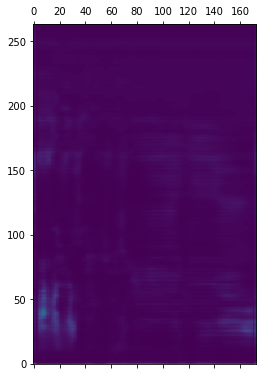

In [76]:
plt.matshow(np.transpose(out[0][1][:,:,0]), fignum=1, aspect='auto', origin='lower')

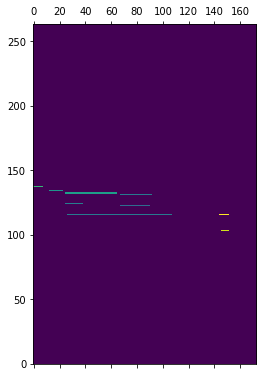

In [77]:
plt.matshow(batched_outputs['contour'][1], fignum=1, aspect='auto', origin='lower')